# **Import & install Important Libraries**

In [ ]:
!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install -U sentence-transformers
!pip install hazm

In [1]:
import hazm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
import copy
from datasets import load_metric , Dataset
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
import sys

import warnings
warnings.filterwarnings("ignore")

# **Import Train Dataset**

In [34]:
data = pd.read_csv('/content/drive/MyDrive/Snappfood - Sentiment Analysis.csv',  on_bad_lines='skip' , delimiter='\t')

In [35]:
data.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  520 non-null    object 
 1   comment     70000 non-null  object 
 2   label       70000 non-null  object 
 3   label_id    69480 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [37]:
data = data[['comment' , 'label_id']]
data.dropna(inplace=True)

In [39]:
data['label_id'] = data['label_id'].astype(int)
data = data.rename(columns={"label_id": "label"})
data.head()

,comment,label
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,0
4,شیرینی وانیلی فقط یک مدل بود.,0


<Axes: >

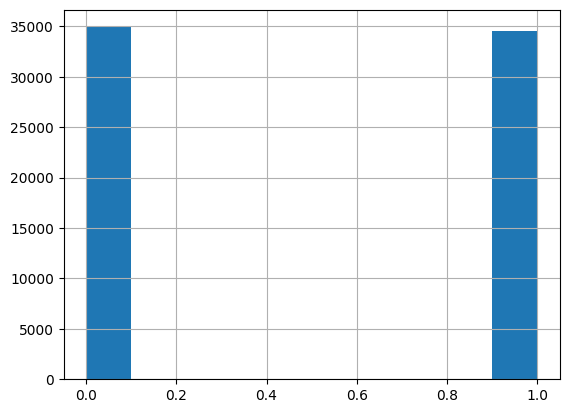

In [40]:
data['label'].hist()

# **Data preprocessing**

In [41]:
normalizer = hazm.Normalizer()

In [42]:
data['normalized_comment'] = data['comment'].apply(lambda c: normalizer.normalize(c.strip()))

In [43]:
data.iloc[1]['comment']

'قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون'

In [44]:
data.iloc[1]['normalized_comment']

'قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدر پلاک خفنهه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون'

# **Train ParsBert model**

In [45]:
checkpointt = "HooshvareLab/bert-base-parsbert-uncased"
config   = AutoConfig   .from_pretrained(checkpointt)
tokenizer = AutoTokenizer.from_pretrained(checkpointt, truncation=True, padding=True, tokenization="byte_level")
model    = AutoModelForSequenceClassification.from_pretrained(checkpointt, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
### split data to train (90%) and valid (10%)

train_data = data.iloc[:7000]
val_data = data.iloc[7000:]

In [47]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(val_data)
# test_dataset  = Dataset.from_pandas(test_data)

def preprocess_function(examples):
    return tokenizer(examples["normalized_comment"], truncation=True, padding=True)

train_dataset = train_dataset.map(preprocess_function)
valid_dataset = valid_dataset.map(preprocess_function)
# test_dataset  = test_dataset .map(preprocess_function, batched=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/62480 [00:00<?, ? examples/s]

In [48]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    return metric.compute(predictions=predictions, references=labels)

In [49]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
from transformers import TrainerCallback, Trainer
import os

class SaveModelCallback(TrainerCallback):
    def __init__(self, output_dir, save_every_n_epochs):
        self.output_dir = output_dir
        self.save_every_n_epochs = save_every_n_epochs

    def on_epoch_end(self, args, state, control, model, **kwargs):
        if (state.epoch + 1) % self.save_every_n_epochs == 0:
            model.save_pretrained(os.path.join(self.output_dir, f"checkpoint-{state.epoch + 1}"))

# Instantiate the SaveModelCallback
save_callback = SaveModelCallback(output_dir="./result", save_every_n_epochs=10)

In [52]:
training_args = TrainingArguments(
    output_dir                  = "./result_parts_bert1",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 3,

    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    # report_to="wandb",

)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[save_callback]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.331030,0.856066
2,No log,0.354147,0.858755
3,0.302300,0.465714,0.851985


TrainOutput(global_step=657, training_loss=0.2626682147950705, metrics={'train_runtime': 1046.0305, 'train_samples_per_second': 20.076, 'train_steps_per_second': 0.628, 'total_flos': 841614155002080.0, 'train_loss': 0.2626682147950705, 'epoch': 3.0})

In [53]:
pred = trainer.predict(valid_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1]) )

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     31432
           1       0.83      0.90      0.86     31048

    accuracy                           0.86     62480
   macro avg       0.86      0.86      0.86     62480
weighted avg       0.86      0.86      0.86     62480



# **Pruning Attention Heads & Encoding layers**

In [55]:
import random

def deleteEncodingLayers(model, num_layers_to_keep):
    oldModuleList = model.bert.encoder.layer
    newModuleList = nn.ModuleList()

    for i in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[i])

    # create a copy of the model, modify it with the new list, and return
    copyOfModel = copy.deepcopy(model)
    copyOfModel.bert.encoder.layer = newModuleList

    return copyOfModel


def generate_dictionary_heads(num_values, num_chosen):
    random.seed(5)
    dictionary = {}
    num_chosen = 12 - num_chosen
    for key in range(0, num_values):
        values = random.sample(range(12), num_chosen)
        dictionary[key] = values

    return dictionary

def RemoveAttentionHeads(model, num_heads_to_keep, num_layers):

  drop_heads = generate_dictionary_heads(num_layers,num_heads_to_keep)
  copyModel = copy.deepcopy(model)
  copyModel.prune_heads(drop_heads)

  return copyModel

def Pruner(model, num_layers_to_keep= 12, num_heads_to_keep= 12):
   new_model = deleteEncodingLayers(model, num_layers_to_keep)
   new_model = RemoveAttentionHeads(new_model, num_heads_to_keep, num_layers_to_keep)
   return new_model

In [56]:
new_model = Pruner(model, num_layers_to_keep= 11, num_heads_to_keep=10)

In [57]:
training_args = TrainingArguments(
    output_dir                  = "./result_pruned_model",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 2,

    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy"
)

trainer = Trainer(
    model           = new_model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.428383,0.841357
2,No log,0.581415,0.851104


TrainOutput(global_step=438, training_loss=0.15461147430280572, metrics={'train_runtime': 604.6284, 'train_samples_per_second': 23.155, 'train_steps_per_second': 0.724, 'total_flos': 485639530756032.0, 'train_loss': 0.15461147430280572, 'epoch': 2.0})

# **Export model to onnxruntime**

## Import & install Important Libraries

In [ ]:
!pip install optimum
!pip install onnxruntime
!pip install onnx
!pip install onnxruntime-extensions

In [59]:
import transformers
from pathlib import Path
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime_extensions.tools import add_pre_post_processing_to_model as add_ppp
from contextlib import contextmanager

## Model Quantization

In [76]:
def get_model(model_path: str = "csarron/mobilebert-uncased-squad-v2"):
    """
    Step 1. Download the model and convert to onnx
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels= 2)
    onnx_config = transformers.models.bert.BertOnnxConfig(config, "sequence-classification")

    model_path = Path('/content/qmodel/parsbert.onnx')
    onnx_inputs, onnx_outputs = transformers.onnx.export(tokenizer, model, onnx_config, 16, model_path)
    return model_path

def quantize_model(model_path: Path):
    """
    Step 2. Quantize the model, so that it can be run on mobile devices with smaller memory footprint
    """
    quantized_model_path = model_path.with_name(model_path.stem+"_quant").with_suffix(model_path.suffix)
    quantize_dynamic(model_path, quantized_model_path, weight_type=QuantType.QInt8)
    model_path.unlink()
    return quantized_model_path


def add_pre_post_process(quantized_model_path: Path, tokenizer):
    """
    Step 3. Add pre and post processing to the model, for tokenization and post processing
    """
    @contextmanager
    def temp_vocab_file():
        vocab_file = quantized_model_path.parent / "vocab.txt"
        yield vocab_file
        vocab_file.unlink()

    tokenizer_type = 'BertTokenizer'
    task_type = 'SequenceClassification'
    output_model_path = quantized_model_path.with_name(
        quantized_model_path.stem+'_with_pre_post_processing').with_suffix(quantized_model_path.suffix)
    with temp_vocab_file() as vocab_file:
        import json
        with open(str(vocab_file), 'w') as f:
            f.write(json.dumps(tokenizer.vocab))
        add_ppp.transformers_and_bert(quantized_model_path, output_model_path, vocab_file, tokenizer_type, task_type,add_debug_before_postprocessing=True)
    quantized_model_path.unlink()
    return output_model_path


In [77]:
model_out_path = Path('/content/qmodel/parsbert.onnx')
model = get_model('/content/result_parts_bert1/checkpoint-1314')
quantized_model = quantize_model(model_path)
output_model = add_pre_post_process(quantized_model, tokenizer)

## Test quantized model

In [78]:
import onnxruntime as _ort
from onnxruntime_extensions import get_library_path as _lib_path

so = _ort.SessionOptions()
so.register_custom_ops_library(_lib_path())

# Run the ONNXRuntime Session as per ONNXRuntime docs suggestions.
sess = _ort.InferenceSession('/content/qmodel/parsbert_quant_with_pre_post_processing.onnx', so)

In [79]:
X_test = ['غذا اصن خوب نبود', 'اعصابم داغونه', 'خیلی خوشمزعه و فوق العاده بود' , 'چه روز قشنگی']
labels_test = [1, 1, 0, 0]

In [82]:
labels = []
for item in X_test:
  model_output = sess.run([output_name], {input_name: [[item]]})
  labels.append(model_output[0].argmax())
  # labels.append(model_output[0].max())

labels

[1, 1, 0, 0]

In [83]:
# Run inference
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
model_output = sess.run([output_name], {input_name: [['واقعا بد مزه بود. این چی بود اخهههههههه']]})
model_output[0].argmax()

1